In [1]:
import cmeutils
import cmeutils.polymers as polymer
from cmeutils.gsd_utils import snap_molecule_cluster
import warnings
warnings.filterwarnings("ignore")
import time
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import mbuild as mb

## Example

This example is for a .gsd file that contains 10 molecuels, each one with 5 monomers
The molecules are united-atom PEEK, so each monomer contains 22 atoms

In [2]:
gsdfile = "100-20mers.gsd"
peek_system = polymer.System(gsd_file=gsdfile, gsd_frame=0, atoms_per_monomer=22)

/home/chris/miniconda3/envs/cmeutils/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Hierarchial structures




In [3]:
print(f"{peek_system.n_molecules} Molecules")
print(f"{peek_system.n_monomers} Monomers")
print(f"{peek_system.n_atoms} Atoms")
print()
print(len((peek_system.molecules)))
print(peek_system.molecules[0:5])

100 Molecules
2000 Monomers
44000 Atoms

100
[<cmeutils.polymers.Molecule object at 0x7f259b8fc310>, <cmeutils.polymers.Molecule object at 0x7f259b8fc790>, <cmeutils.polymers.Molecule object at 0x7f259b903910>, <cmeutils.polymers.Molecule object at 0x7f259bcd2fd0>, <cmeutils.polymers.Molecule object at 0x7f259b903e90>]


/home/chris/miniconda3/envs/cmeutils/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Looking at just 1 of the molecule objects from peek_system.molecules

In [4]:
molecule_1 = peek_system.molecules[0]
print(f"{molecule_1.n_monomers} Monomers")
print(f"{molecule_1.n_atoms} Atoms")
print()
print(len(molecule_1.monomers))
print(molecule_1.monomers[0:5])

20 Monomers
440 Atoms

20
[<cmeutils.polymers.Monomer object at 0x7f259b903990>, <cmeutils.polymers.Monomer object at 0x7f259b9039d0>, <cmeutils.polymers.Monomer object at 0x7f259b903a10>, <cmeutils.polymers.Monomer object at 0x7f259b903a50>, <cmeutils.polymers.Monomer object at 0x7f259b903a90>]


/home/chris/miniconda3/envs/cmeutils/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Looking at just 1 of the monomer objects from molecule_1

In [5]:
monomer_1 = molecule_1.monomers[0]
print(f"{monomer_1.n_atoms} Atoms")

22 Atoms


/home/chris/miniconda3/envs/cmeutils/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Properties at each structure level

In [6]:
print(molecule_1.center)
print(monomer_1.center)
print(molecule_1.end_to_end_distance())

[  8.22849751  -6.37031364 -12.47945309]
[  9.28754139  -3.69121075 -10.02487183]
37.08326032846742


/home/chris/miniconda3/envs/cmeutils/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Generating Components

There is a `Component` class that will allow you to group atoms together in structures that are smaller than the groupings in the `Monomer` class.

Right now, what is required is a dictionary of `name: indices`.

These indices are how the substructure exists within a single monomer, no the entire system.  For example, with PEEK which consists of 3 ring-like structures.  Two of them are identical, labeled `A` below, and the third is labeled `B`.  Since there are 2 `A` components, the indices passed into the dictionary are a list of 2 lists.

In [7]:
comp_mapping = {
    "A": [[0, 1, 2, 3, 4, 20, 21], [5, 6, 7, 8, 9, 18, 19]],
    "B": [10, 11, 12, 13, 14, 15, 16, 17]
}

for monomer in peek_system.monomers():
    monomer.generate_components(index_mapping = comp_mapping)

/home/chris/miniconda3/envs/cmeutils/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Accessing each Component within the system.

In [8]:
all_components = [comp for comp in peek_system.components()]
print(len(all_components))

6000


/home/chris/miniconda3/envs/cmeutils/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Generating Segments

So far, we've seen that structure groupings are automatically created at the molecule and monomer level. Then, with some inputs, we could create component-level structure groupings (smaller than a monomer). Using the `generate_segments()` method available in the `Molecule` class will let us create structure groupings at a scale of multiple monomers, but still smaller than a molecule.

Just like the `Components` class, this requires some input.  In this case, we have to define how many monomers are contained in each segment. For example, if we want segments to contain 4 monomers:

In [28]:
for mol in peek_system.molecules:
    mol.generate_segments(monomers_per_segment = 4) # We're saying 4 monomers per segment

/home/chris/miniconda3/envs/cmeutils/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Bond length and angle distributions

We can obtain information about the structure of the system at level more coarse than atomistic. For example, we might want to see the distribution of "bond" lengths and angles between monomers or segments.

The `System` class contains a function for each type of distribution.  The data is returned, and with the `plot` parameter you can see a plot of the distribution.

/home/chris/miniconda3/envs/cmeutils/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


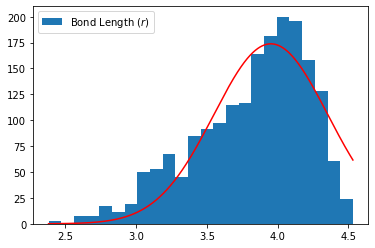

In [29]:
bond_dist = peek_system.bond_length_distribution(nbins=20, plot=True)

/home/chris/miniconda3/envs/cmeutils/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


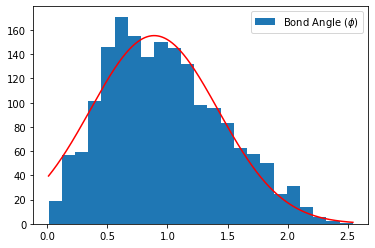

In [30]:
ang_dist = peek_system.bond_angle_distribution(nbins=20, plot=True)

## Bond lengths and angles between segments

The examples above used the bond distances and angles between monomers, but we can use the same methods on segments by changing the `user_monomers` and `use_segments` parameters in each function call.

/home/chris/miniconda3/envs/cmeutils/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


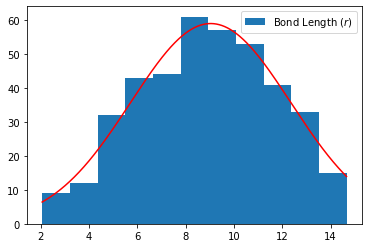

In [34]:
seg_bond_dist = peek_system.bond_length_distribution(use_monomers=False, use_segments=True, plot=True)

/home/chris/miniconda3/envs/cmeutils/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


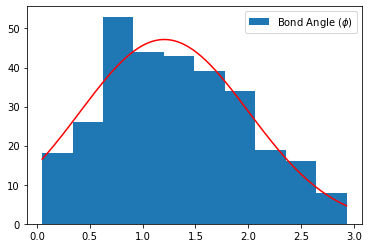

In [35]:
seg_angle_dist = peek_system.bond_angle_distribution(use_monomers=False, use_segments=True, plot=True)

# Coarse-graining

We can use the center of mass methods and Molecule and Monomer classes to generate a coarse-grained representation of the UA system:

**NOTE:**
This requires that mbuild and py3Dmol are installed

`conda install -c conda-forge mbuild py3Dmol`

In [11]:
import mbuild as mb

/home/chris/miniconda3/envs/cmeutils/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Example: Using the Component() class to create a coarse-grained system

In [36]:
import time

start = time.time()
cg_components = mb.Compound()
molecules = []
for mol in peek_system.molecules:
    mol_comp = mb.Compound()
    last_bead = None
    for mon_idx, mon in enumerate(mol.monomers):
        for comp_idx, comp in enumerate(mon.components):
            pos = comp.unwrapped_center / 10
            bead = mb.Compound(name=comp.name, pos=pos)
            mol_comp.add(bead)
            if mon_idx == 0 and comp_idx == 0:
                pass
            else:
                mol_comp.add_bond((bead, last_bead))
            last_bead = bead
    cg_components.add(mol_comp)
finish = time.time()
#cg_components.save("components_cg.gsd", overwrite=True)
print(finish - start)

cg_components.visualize(color_scheme = {"A": "blue", "B": "orange"}) 

/home/chris/miniconda3/envs/cmeutils/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.6019623279571533


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Example: Using the Monomer() class to create a coarse-grained system

Using mBuild, and the tools described above, we can generate a coarse-grained representation of the system where 1 bead is equivalent to 1 monomer from the united-atom system.

In [27]:
start = time.time()
cg_monomers = mb.Compound()
for mol_idx, molecule in enumerate(peek_system.molecules):
    molecule_comp = mb.Compound(name=f"mol{mol_idx}")
    last_bead = None
    for mon_idx, monomer in enumerate(molecule.monomers):
        bead_name = f"mol{mol_idx}_mon{mon_idx}"
        #pos = monomer.unwrapped_center * 3.3996695084235347
        pos = monomer.unwrapped_center / 10
        bead = mb.Compound(name=bead_name, pos=pos)
        molecule_comp.add(bead)
        if 0 < mon_idx < len(molecule.monomers):
            molecule_comp.add_bond((bead, last_bead))
        last_bead = bead
    cg_monomers.add(molecule_comp)
    
#cg_monomers.save("monomers_cg.gsd", overwrite=True)
finish = time.time()
print(finish - start)

cg_monomers.visualize()

/home/chris/miniconda3/envs/cmeutils/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.34014248847961426


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

## Example: Using the Segment() class to create a coarse-grained system:

When creating a system object, the Molecule objects are automatically generated, and each time a `Molecule` class is instantiated, the `Monomer` objects are automatically created.

In order to create `Segment` instances, we will have to call the `generate_segments` method for each `Molecule` object.  The important parameter of input is defining how many monomers 1 segment consists of.

In [18]:
start = time.time()
cg_segments = mb.Compound()

for mol_idx, molecule in enumerate(peek_system.molecules):
    molecule_comp = mb.Compound(name=f"mol{mol_idx}")
    last_bead = None
    for seg_idx, segment in enumerate(molecule.segments):
        bead_name = f"mol{mol_idx}_mon{seg_idx}"
        #pos = monomer.unwrapped_center * 3.3996695084235347
        pos = segment.unwrapped_center / 10
        bead = mb.Compound(name=bead_name, pos=pos)
        molecule_comp.add(bead)
        if 0 < seg_idx < len(molecule.monomers):
            molecule_comp.add_bond((bead, last_bead))
        last_bead = bead
    cg_segments.add(molecule_comp)

finish = time.time()
print(finish - start)

cg_segments.visualize()

0.04980182647705078


/home/chris/miniconda3/envs/cmeutils/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol